In [1]:
import pandas as pd
import seaborn as sns
import gradio as gr
import warnings
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.exceptions import DataConversionWarning

%matplotlib inline

warnings.filterwarnings(action='ignore', category=UserWarning, message='X does not have valid feature names')


# Load the dataset
df = pd.read_csv('merged_cost_and_salary.csv')
df.columns = df.columns.str.strip()  # Strip whitespace from the column names

# Calculate the Combined Cost of Living Index (including rent)
df['Combined_Cost_Index'] = df['Cost of Living Index'] + df['Rent Index']

# Calculate the cost of living as a percentage of the local average net salary
df['Cost_of_Living_as_Percentage_of_Salary'] = (df['Combined_Cost_Index'] / df['Average Monthly Net Salary']) * 100

# Find a threshold that marks the top x% as not feasible
threshold = df['Cost_of_Living_as_Percentage_of_Salary'].quantile(0.60)

# Create a binary target variable: 1 if the cost of living as a percentage of salary is less than the threshold, 0 otherwise
df['Feasible'] = (df['Cost_of_Living_as_Percentage_of_Salary'] < threshold).astype(int)

# Check the distribution of the target variable
print(df['Feasible'].value_counts())

# Prepare the data for the logistic regression model
X = df[['Cost_of_Living_as_Percentage_of_Salary']]  # Features
y = df['Feasible']  # Target variable

# Split the dataset into training and test sets with stratification
if len(y.unique()) > 1:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
else:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize and train the logistic regression model
model = LogisticRegression()
model.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred = model.predict(X_test_scaled)

# Evaluation
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Feasible
1    231
0    154
Name: count, dtype: int64
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        31
           1       1.00      1.00      1.00        46

    accuracy                           1.00        77
   macro avg       1.00      1.00      1.00        77
weighted avg       1.00      1.00      1.00        77

Confusion Matrix:
 [[31  0]
 [ 0 46]]


In [2]:
# Function to predict feasibility of living in a city based on user's average monthly salary
def predict_feasibility(city, average_net_salary):
    # Get the city's cost of living and rent indices
    cost_of_living_index = df[df['City'] == city]['Cost of Living Index'].values[0]
    rent_index = df[df['City'] == city]['Rent Index'].values[0]
    
    # Calculate the combined cost index
    combined_cost_index = cost_of_living_index + rent_index
    
    # Calculate the cost of living as a percentage of the provided average net salary
    cost_of_living_percentage = (combined_cost_index / average_net_salary) * 100
    
    # Scale the cost of living percentage
    cost_of_living_percentage_scaled = scaler.transform([[cost_of_living_percentage]])
    
    # Predict the feasibility using the scaled percentage
    feasibility = model.predict(cost_of_living_percentage_scaled)[0]
    
    return "Feasible" if feasibility == 1 else "Not Feasible"

# Create the dropdown options from the unique cities in the dataframe
city_options = df['City'].unique().tolist()

# Create a Gradio interface
iface = gr.Interface(
    fn=predict_feasibility, 
    inputs=[
        gr.Dropdown(choices=city_options, label="City"),
        gr.Number(label="Average Monthly Net Salary")
    ], 
    outputs="text"
)

# Launch the interface
iface.launch(inline=True)

Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


## Histogram of Cost of Living as Percentage of Salary
This histogram shows the distribution of cities based on the cost of living as a percentage of the average monthly net salary. The x-axis represents the percentage of salary that goes towards the cost of living, while the y-axis shows how many cities fall into each percentage bracket.

If the histogram shows that most cities cluster at the lower end of the percentage scale, this indicates that in most cities, a smaller portion of the average salary is needed to cover the cost of living. This is useful for spotting general trends and identifying outliers—cities that might be significantly more or less expensive than others.

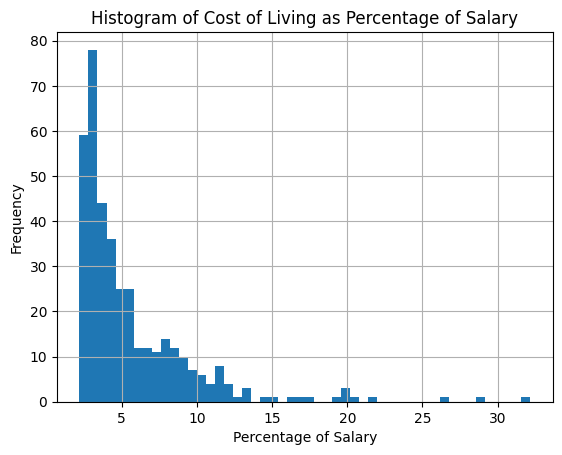

In [18]:
df['Cost_of_Living_as_Percentage_of_Salary'].hist(bins=50)
plt.title('Histogram of Cost of Living as Percentage of Salary')
plt.xlabel('Percentage of Salary')
plt.ylabel('Frequency')
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(df['Cost_of_Living_as_Percentage_of_Salary'], y, c=df['Feasible'], cmap='coolwarm', label='Feasible')
plt.axvline(x=threshold, color='k', linestyle='--', label='Threshold')
plt.title('Feasibility by Cost of Living Percentage')
plt.xlabel('Cost of Living as Percentage of Salary')
plt.ylabel('Feasibility')
plt.legend()
plt.show()


## Confusion Matrix:
The confusion matrix is a table used to describe the performance of a classification model on a set of test data for which the true values are known. Here's how to read the matrix:

- **Top-Left Square (True Not Feasible)**: The number of cities correctly predicted as not feasible (the model predicted 'not feasible', and they indeed are not feasible).
- **Top-Right Square (False Feasible)**: The number of cities incorrectly predicted as feasible (the model predicted 'feasible', but they are not feasible).
- **Bottom-Left Square (False Not Feasible)**: The number of cities incorrectly predicted as not feasible (the model predicted 'not feasible', but they are actually feasible).
- **Bottom-Right Square (True Feasible)**: The number of cities correctly predicted as feasible (the model predicted 'feasible', and they indeed are feasible).

The high numbers on the diagonal (top-left and bottom-right) suggest that the model is performing well, correctly identifying the feasibility status of most cities. If the off-diagonal numbers were high, it would indicate the model is making more incorrect predictions.


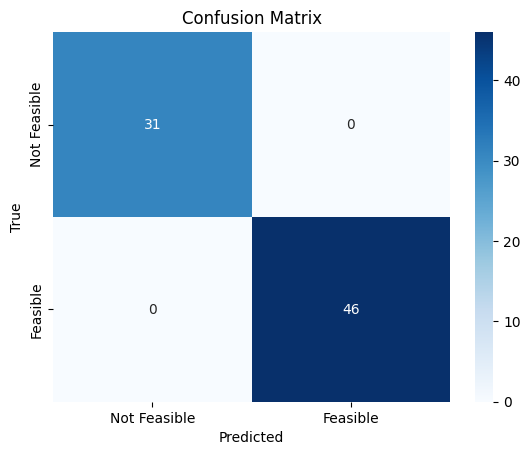

In [19]:
conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Feasible', 'Feasible'], yticklabels=['Not Feasible', 'Feasible'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## Scatterplot Analysis

The scatterplot visualizes the relationship between the cost of living as a percentage of salary and the feasibility of relocating to different cities.

- **Horizontal Axis (Cost of Living as Percentage of Salary)**: Indicates how much of an individual's salary would potentially be spent on living costs.
- **Vertical Axis (Feasibility)**: Shows the binary classification of feasibility, with `1` being feasible and `0` being not feasible for relocation.
- **Data Points**: Represent individual cities, plotted according to their respective cost of living percentage and feasibility classification.
- **Dashed Vertical Line**: Marks the threshold percentage beyond which cities are deemed not feasible for relocation.

The distribution of data points provides insight into the classification model's performance, with most cities deemed feasible clustering below the threshold line.


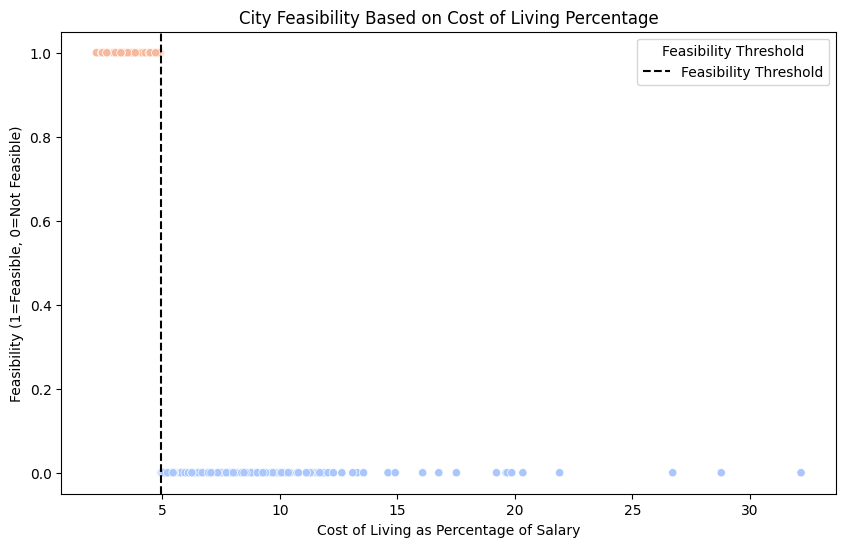

In [3]:
# Scatter plot for Cost of Living as Percentage of Salary by Feasibility
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Cost_of_Living_as_Percentage_of_Salary', y='Feasible', hue='Feasible', data=df, palette='coolwarm', legend=None)
plt.axvline(x=threshold, color='k', linestyle='--', label='Feasibility Threshold')
plt.title('City Feasibility Based on Cost of Living Percentage')
plt.xlabel('Cost of Living as Percentage of Salary')
plt.ylabel('Feasibility (1=Feasible, 0=Not Feasible)')
plt.legend(title='Feasibility Threshold')
plt.show()
